# Command: A new tool for building multi-agent architectures in LangGraph


Building agentic and multi-agent systems is all about communication.

Now, nodes can dynamically decide which node to execute next, improving flexibility and simplifying complex workflows.

#### **What's New:**
- **Edgeless graphs:** Nodes no longer need edges to connect. Instead, they can directly specify which node to go to next, making your agent flows more intuitive and adaptable.

- **Enhanced control:** Control the flow after the state update by returning a Command that points to the next node, enabling dynamic, real-time decision-making.

In [1]:
%%capture --no-stderr
%pip install -U langgraph

Let's learn it with a simple example - An
AI-powered home search engine like: https://flyhomes.com/.


In [2]:
import random
from typing import Annotated, TypedDict, Literal, Optional

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

# This is new
from langgraph.types import Command

## S1: Understand Command Basic Usage

In [3]:
# Define graph state
class State(TypedDict):
    address: str # address where user wants to search homes for.
    nearby_homes: Optional[list[dict]] # list of nearby homes
    messages: Annotated[list, add_messages]

In [4]:
# Define the nodes (agents)

def node_a(state: State) -> Command[Literal["search_nearby_homes", "answer_question"]]: #Here telling about which node it will go
    print("Called A")

    # THis is where llm decides which node shall I go next
    value = random.choice(["search_nearby_homes", "answer_question"])

    # This is a replacement for a conditional edge function
    if value == "search_nearby_homes":
        goto = "search_nearby_homes"
    else:
        goto = "answer_question"

    # note how Command allows you to BOTH update the graph state AND route to the next node

    return Command( # previous we return state.Now,we are returning Command
        # this is a replacement for an edge
        goto=goto,
    )


# Nodes search_nearby_homes and answer_question are unchanged (just like before)
def search_nearby_homes(state: State):
    print("Called search_nearby_homes!")
    return {"nearby_homes": [{"home_1": "Zia House"}, {"home_2": "Qasim House"}]}


def answer_question(state: State):
    print("Called answer_question")
    return {"messages": [AIMessage(content="System is down - please try later")]}

In [5]:
builder = StateGraph(State)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(search_nearby_homes)
builder.add_node(answer_question)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()

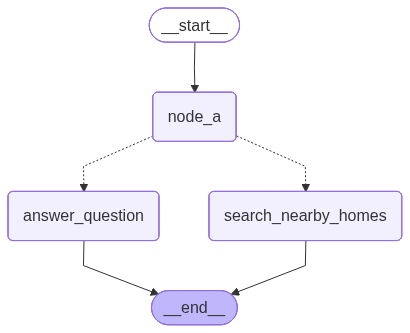

In [6]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
agent_response = graph.invoke({"address": "Karachi"})

print("\n[FINAL RESPONSE]\n", agent_response)

Called A
Called search_nearby_homes!

[FINAL RESPONSE]
 {'address': 'Karachi', 'nearby_homes': [{'home_1': 'Zia House'}, {'home_2': 'Qasim House'}], 'messages': []}


In [7]:
agent_response = graph.invoke({"address": "Karachi"})

print("\n[FINAL RESPONSE]\n", agent_response)

Called A
Called answer_question

[FINAL RESPONSE]
 {'address': 'Karachi', 'messages': [AIMessage(content='System is down - please try later', additional_kwargs={}, response_metadata={}, id='2a632a6f-485d-4403-a1c0-eb8005e240ad')]}


## S2: Update State using Command

After node_1 we can update our state as well. So if user is already in our system we can add it's user data in the stage to personalize user experience.

In [10]:
# Define graph state
class State(TypedDict):
    address: str # address where user wants to search homes for.
    nearby_homes: Optional[list[dict]] # list of nearby homes
    messages: Annotated[list, add_messages]
    user_data: Optional[dict] # user data - for registered users we already have this

In [11]:
# Define the nodes (agents)

def node_a(state: State) -> Command[Literal["search_nearby_homes", "answer_question"]]:
    print("Called A",state)

    # Get User Data From Memory or Data Store
    fetched_user_data = {"name": "Ammen Alam"}

    # THis is where llm decides which node shall I go next
    value = random.choice(["search_nearby_homes", "answer_question"])

    # This is a replacement for a conditional edge function
    if value == "search_nearby_homes":
        goto = "search_nearby_homes"
    else:
        goto = "answer_question"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        update={"user_data": fetched_user_data,"address": "Lahore"},
        # this is a replacement for an edge
        goto=goto,
    )


# Nodes search_nearby_homes and answer_question are unchanged (just like before)
def search_nearby_homes(state: State):
    print("Called search_nearby_homes!")
    print("UserInfo", state["user_data"])
    return {"nearby_homes": [{"home_1": "Zia House"}, {"home_2": "Qasim House"}]}


def answer_question(state: State):
    print("Called answer_question")
    print("UserInfo", state["user_data"])
    user_name = state["user_data"].get("name", "Guest")
    return {"messages": [AIMessage(content=f"Hi, {user_name} Welcome to Homes AI Search Engine")]}

In [12]:
builder = StateGraph(State)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(search_nearby_homes)
builder.add_node(answer_question)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()

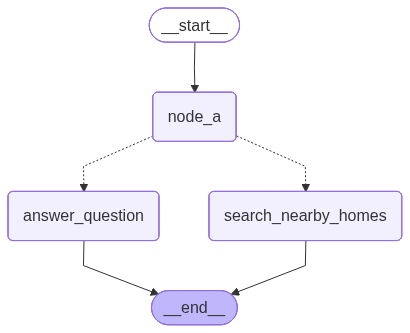

In [13]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
agent_response = graph.invoke({"address": "Karachi"})

print("\n[FINAL RESPONSE]\n", agent_response)

Called A {'address': 'Karachi', 'messages': []}
Called search_nearby_homes!
UserInfo {'name': 'Ammen Alam'}

[FINAL RESPONSE]
 {'address': 'Lahore', 'nearby_homes': [{'home_1': 'Zia House'}, {'home_2': 'Qasim House'}], 'messages': [], 'user_data': {'name': 'Ammen Alam'}}


In [15]:
agent_response = graph.invoke({"address": "Karachi"})

print("\n[FINAL RESPONSE]\n", agent_response)

Called A {'address': 'Karachi', 'messages': []}
Called answer_question
UserInfo {'name': 'Ammen Alam'}

[FINAL RESPONSE]
 {'address': 'Lahore', 'messages': [AIMessage(content='Hi, Ammen Alam Welcome to Homes AI Search Engine', additional_kwargs={}, response_metadata={}, id='ab4e3b0a-f770-42fb-93a8-736d732269b0')], 'user_data': {'name': 'Ammen Alam'}}


# S3: Run Nodes(Agents) in Parallel


Now our user requirement is to both find homes and have conversation with user.
For this:

- We shall call Both Nodes in Parrallel

In [16]:
# Define graph state
class State(TypedDict):
    address: str # address where user wants to search homes for.
    nearby_homes: Optional[list[dict]] # list of nearby homes
    messages: Annotated[list, add_messages]
    user_data: Optional[dict] # user data - for registered users we already have this

In [17]:
# Define the nodes (agents)

def node_a(state: State) -> Command[Literal["search_nearby_homes", "answer_question"]]:
    print("Called A")

    # Get User Data From Memory or Data Store
    fetched_user_data = {"name": "Ammen Alam"}

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        update={"user_data": fetched_user_data},
        # this is a replacement for an edge
        goto=["search_nearby_homes", "answer_question"], # Now,it will run nodes in parallel
    )


# Nodes search_nearby_homes and answer_question are unchanged (just like before)
def search_nearby_homes(state: State):
    print("Called search_nearby_homes!")
    print("UserInfo", state["user_data"])
    return {"nearby_homes": [{"home_1": "Zia House"}, {"home_2": "Qasim House"}]}


def answer_question(state: State):
    print("Called answer_question")
    print("UserInfo", state["user_data"])
    user_name = state["user_data"].get("name", "Guest")
    return {"messages": [AIMessage(content=f"Hi, {user_name} Welcome to Homes AI Search Engine")]}

In [18]:
builder = StateGraph(State)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(search_nearby_homes)
builder.add_node(answer_question)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()

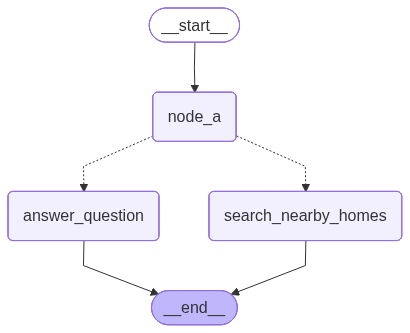

In [19]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
agent_response = graph.invoke({"address": "Karachi"})

print("\n[FINAL RESPONSE]\n", agent_response)

Called A
Called answer_question
UserInfo {'name': 'Ammen Alam'}
Called search_nearby_homes!
UserInfo {'name': 'Ammen Alam'}

[FINAL RESPONSE]
 {'address': 'Karachi', 'nearby_homes': [{'home_1': 'Zia House'}, {'home_2': 'Qasim House'}], 'messages': [AIMessage(content='Hi, Ammen Alam Welcome to Homes AI Search Engine', additional_kwargs={}, response_metadata={}, id='045eebfb-6736-4b8d-b9a0-0519f7b8a297')], 'user_data': {'name': 'Ammen Alam'}}


##

*Question: What will happen if two nodes running in parallel try update same key in state*

In [41]:
# Define graph state
class State(TypedDict):
    address: str # address where user wants to search homes for.
    nearby_homes: Optional[list[dict]] # list of nearby homes
    messages: Annotated[list, add_messages]
    user_data: Optional[dict] # user data - for registered users we already have this

In [42]:
# Define the nodes (agents)

def node_a(state: State) -> Command[Literal["search_nearby_homes", "answer_question"]]:
    print("Called A")

    # Get User Data From Memory or Data Store
    fetched_user_data = {"name": "Ammen Alam"}

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        update={"user_data": fetched_user_data},
        # this is a replacement for an edge
        goto=["search_nearby_homes", "answer_question"], # Now,it will run nodes in parallel
    )


# Nodes search_nearby_homes and answer_question are unchanged (just like before)
def search_nearby_homes(state: State) -> Command[Literal["answer_question"]]:
    print("Called search_nearby_homes!")
    print("UserInfo", state["user_data"])
    return Command(
        update={"nearby_homes": [{"home_1": "Zia House"}, {"home_2": "Qasim House"}],'user_data': {'name': 'Areeb'}},
        # this is a replacement for an edge
        goto=["answer_question"], # Now,it will run nodes in parallel
    )


def answer_question(state: State):
    print("Called answer_question")
    print("UserInfo", state["user_data"])
    user_name = state["user_data"].get("name", "Guest")
    return {"messages": [AIMessage(content=f"Hi, {user_name} Welcome to Homes AI Search Engine")]}

In [43]:
builder = StateGraph(State)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(search_nearby_homes)
builder.add_node(answer_question)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()

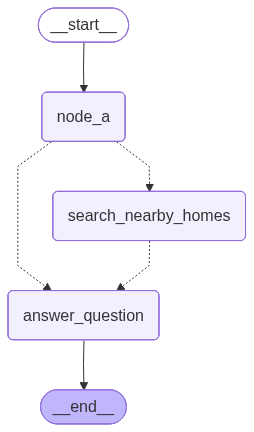

In [44]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
agent_response = graph.invoke({"address": "Karachi"})

print("\n[FINAL RESPONSE]\n", agent_response)

Called A
Called answer_question
UserInfo {'name': 'Ammen Alam'}
Called search_nearby_homes!
UserInfo {'name': 'Ammen Alam'}
Called answer_question
UserInfo {'name': 'Areeb'}

[FINAL RESPONSE]
 {'address': 'Karachi', 'nearby_homes': [{'home_1': 'Zia House'}, {'home_2': 'Qasim House'}], 'messages': [AIMessage(content='Hi, Ammen Alam Welcome to Homes AI Search Engine', additional_kwargs={}, response_metadata={}, id='caa8644b-d680-4081-98ee-f971fa56ac92'), AIMessage(content='Hi, Areeb Welcome to Homes AI Search Engine', additional_kwargs={}, response_metadata={}, id='beedbcb7-d20a-4925-bc44-b2a9165ceb63')], 'user_data': {'name': 'Areeb'}}


*In node_a replace that random with an llm and it will decide in which node to go next.*

In [55]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai

In [56]:
# Define graph state
class State(TypedDict):
    address: str # address where user wants to search homes for.
    nearby_homes: Optional[list[dict]] # list of nearby homes
    messages: Annotated[list, add_messages]
    user_data: Optional[dict] # user data - for registered users we already have this

In [57]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [82]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-2.0-flash")

# Define Node A with LLM decision logic
def node_a(state: State) -> Command[Literal["search_nearby_homes", "answer_question"]]:
    print("Called node_a", state)

    # Step 1: Fetch user data (simulating retrieval)
    fetched_user_data = {"name": "Ammen Alam"}

    # Step 2: Ask LLM which route to take
    prompt = f"""
    You are a routing assistant in a home search system.

    Reply with only one of these exact words:
    - search_nearby_homes
    - answer_question
    """

    llm_response = llm.invoke(prompt).content.strip().lower()

    if llm_response not in ["search_nearby_homes", "answer_question"]:
        llm_response = "answer_question"  # fallback

    goto = llm_response

    # Step 3: Return the command
    return Command(
        update={"user_data": fetched_user_data, "address": "Lahore"},
        goto=goto,
    )

# Other nodes remain unchanged
def search_nearby_homes(state: State):
    print("Called search_nearby_homes!")
    print("UserInfo", state["user_data"])
    return {"nearby_homes": [{"home_1": "Zia House"}, {"home_2": "Qasim House"}]}

def answer_question(state: State):
    print("Called answer_question")
    print("UserInfo", state["user_data"])
    user_name = state["user_data"].get("name", "Guest")
    return {"messages": [AIMessage(content=f"Hi, {user_name}! Welcome to Homes AI Search Engine.")]}

In [83]:
builder = StateGraph(State)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(search_nearby_homes)
builder.add_node(answer_question)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()

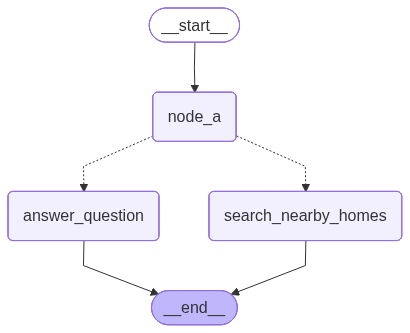

In [84]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [85]:
agent_response = graph.invoke({"address": "Karachi"})

print("\n[FINAL RESPONSE]\n", agent_response)

Called node_a {'address': 'Karachi', 'messages': []}
Called search_nearby_homes!
UserInfo {'name': 'Ammen Alam'}

[FINAL RESPONSE]
 {'address': 'Lahore', 'nearby_homes': [{'home_1': 'Zia House'}, {'home_2': 'Qasim House'}], 'messages': [], 'user_data': {'name': 'Ammen Alam'}}


In [86]:
agent_response = graph.invoke({"message": "Hello"})

print("\n[FINAL RESPONSE]\n", agent_response)

Called node_a {'messages': []}
Called answer_question
UserInfo {'name': 'Ammen Alam'}

[FINAL RESPONSE]
 {'address': 'Lahore', 'messages': [AIMessage(content='Hi, Ammen Alam! Welcome to Homes AI Search Engine.', additional_kwargs={}, response_metadata={}, id='aae8df82-eeb8-4cee-b45e-53ba9ba49580')], 'user_data': {'name': 'Ammen Alam'}}


## Final Notes


- **Task**: In `node_a` replace that random with an llm and it will decide in which node to go next.

- **Question:** What will happen if two nodes running in parallel try update same key in state (Think about reducers and find your answer in Module 4)

References:
- https://langchain-ai.github.io/langgraph/how-tos/command/#define-graph
- https://blog.langchain.dev/command-a-new-tool-for-multi-agent-architectures-in-langgraph/